We first import the necessary libraries and get our data.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA


filepath = '/Users/gracemcmonagle/Desktop/School/Fall 2020/EECS 731/Project 5/src/data/Historical Product Demand.csv'
rawData = pd.read_csv(filepath, delimiter = ',')
rawData['Date'] = pd.to_datetime(rawData['Date'], format='%Y/%m/%d')

We now want to do a bit of exploratory data analysis. We will first look at the number of each different product and make sure there are no NaN values. 

In [24]:
noProducts = rawData['Product_Code'].value_counts(dropna=False)
print(noProducts.head())

Product_1359    16936
Product_1295    10575
Product_1378     9770
Product_0620     9428
Product_1286     8888
Name: Product_Code, dtype: int64


Now, let's examine the warehouse and product category variables.

In [25]:
rawData['Warehouse'].value_counts(dropna=False)
rawData['Product_Category'].value_counts(dropna=False)

Category_019    481099
Category_005    101671
Category_001     97787
Category_007     82402
Category_021     52011
Category_006     35577
Category_028     31302
Category_011     23208
Category_015     22954
Category_024     20885
Category_009     19738
Category_026     14803
Category_030     12997
Category_032      9296
Category_022      8657
Category_023      7899
Category_018      5239
Category_003      4189
Category_013      3743
Category_020      3490
Category_031      2280
Category_033      1849
Category_008      1560
Category_012      1147
Category_010       976
Category_029       671
Category_017       615
Category_004       329
Category_002        77
Category_016        37
Category_025        35
Category_027        26
Category_014        26
Name: Product_Category, dtype: int64

In this project, our goal is to forecast the demand for a certain product. So, given a certain product, we are going to create a couple different models to forecast its future demand. First we are going to use Exponential Smoothing.

In [26]:
def expSmoothingForecast(specProd, prod):
    noOrdersByMonth = pd.DataFrame(specProd.groupby(specProd['Date'].dt.strftime('%Y/%m'))['Orders'].sum())
    demandByMonth = pd.DataFrame(specProd.groupby(specProd['Date'].dt.strftime('%Y/%m'))['Order_Demand'].sum())
    noOrdersByMonth['Month'] = noOrdersByMonth.index
    noOrdersByMonth['Month'] = pd.to_datetime(noOrdersByMonth['Month'], format='%Y/%m')
    byMonth = pd.concat([noOrdersByMonth, demandByMonth], axis = 1)   
    byMonth = byMonth.sort_values(by=['Month'])
    
    demandData = pd.Series(byMonth['Order_Demand'], byMonth['Month'])
    
    
    fit1 = SimpleExpSmoothing(demandData).fit(smoothing_level=0.2,optimized=False)
    fcast1 = fit1.forecast(3).rename(r'$\alpha=0.2$')
    fit2 = SimpleExpSmoothing(demandData).fit(smoothing_level=0.6,optimized=False)
    fcast2 = fit2.forecast(3).rename(r'$\alpha=0.6$')
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(demandData, marker='o', color='black')
    plt.plot(fit1.fittedvalues, marker='o', color='blue')
    line1, = plt.plot(fcast1, marker='o', color='blue')
    plt.plot(fit2.fittedvalues, marker='o', color='red')
    line2, = plt.plot(fcast2, marker='o', color='red')
    plt.title('Exponential Smoothing Forecasting for ' + prod)
    plt.xlabel('Month')
    plt.ylabel('Order Demand')
    plt.legend([line1, line2], [fcast1.name, fcast2.name])

In the above block, we define the exponential smoothing forecast model. The first six lines we are getting our data ready for the forecast. We collapse the data by month so that our data is evenly spaced (we don't have daily data for most of our products). 

Now, we create our whole dataset and begin to fit our exponential smoothing model. We fit two different models with two different smoothing levels to see how that effects the prediction. 

Finally, we plot the original data and our results.

For this forecasting method, we are going to first forecast for product 1341. When beginning the forecasting product, we notice that some of the order demands are entered with '()' around the numerical value, so we write a short for loop to strip those off of the string. We then run our filtered data through the function we wrote for exponential smoothing.

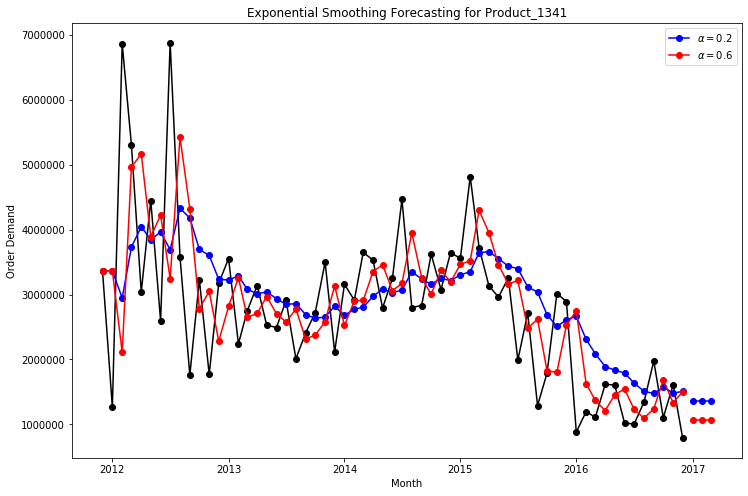

In [27]:
specProd = rawData[rawData['Product_Code'] == 'Product_1341']
specProd.sort_values(by=['Date'])
#plt.hist(specProd['Order_Demand'])

prod = []
for index, row in specProd.iterrows():
    if row['Order_Demand'][0] == '(':
        n = len(row['Order_Demand'])
        row['Order_Demand'] = row['Order_Demand'][1:n-1]
    prod.append(np.asarray(row))

specProd = pd.DataFrame(prod)
specProd.columns = ['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand']    
specProd['Order_Demand'] = pd.to_numeric(specProd['Order_Demand'])



specProd['Order_Demand'] = pd.to_numeric(specProd['Order_Demand'])
#plt.plot(specProd['Date'], specProd['Order_Demand'])

#no of orders on a specific day
specProd['Orders'] = specProd.groupby('Date')['Product_Code'].transform('count')
specProd['Demand'] = specProd.groupby('Date')['Order_Demand'].transform('sum')
expSmoothingForecast(specProd, 'Product_1341')

We can see here that the higher $\alpha$ values matches the peaks better of the data. This would be because the data is "smoothed" less than in the other case. 

Now, we are going to also forecast this data with the ARIMA method. Once again, we write a function for this forecasting method.

In [28]:
def ARIMAForecast(specProd, prod):    
    noOrdersByMonth = pd.DataFrame(specProd.groupby(specProd['Date'].dt.strftime('%Y/%m'))['Orders'].sum())
    demandByMonth = pd.DataFrame(specProd.groupby(specProd['Date'].dt.strftime('%Y/%m'))['Order_Demand'].sum())
    noOrdersByMonth['Month'] = noOrdersByMonth.index
    noOrdersByMonth['Month'] = pd.to_datetime(noOrdersByMonth['Month'], format='%Y/%m')
    
    byMonth = pd.concat([noOrdersByMonth, demandByMonth], axis = 1)
    
    byMonth = byMonth.sort_values(by=['Month'])
    #plt.scatter(byDay['Day'], byDay['Orders'])
    #plt.show()
    
    #plt.scatter(byDay['Day'], byDay['Demand'])
    demandData = pd.Series(byMonth['Order_Demand'], byMonth['Month'])
    
    mod = ARIMA(demandData, order = (5,1,0))
    model_fit = mod.fit()
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot(kind='kde')
    plt.title('ARIMA Residuals for ' + prod)
    plt.show()

As in the exonential smoothing function we prepare the data for our forecaster the same way. We then define the ARIMA model. The parameters for $\texttt{order}$ define how much of the data we take into consideration when training and making predictions around a certain point. We then plot the ARIMA model residuals and look at the distribution of the residuals. 

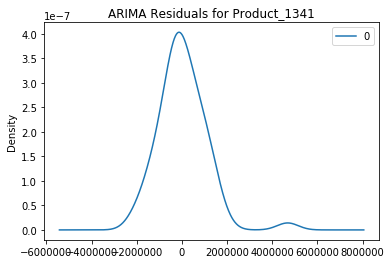

In [29]:
ARIMAForecast(specProd, 'Product_1341')

Now we want to pick a different product and run the same forecasting methods. So, let's pick product 0211 and look at how these forecasting methods work for it. We prepare the data for this product in the same way as we did before and run our two functions as before.

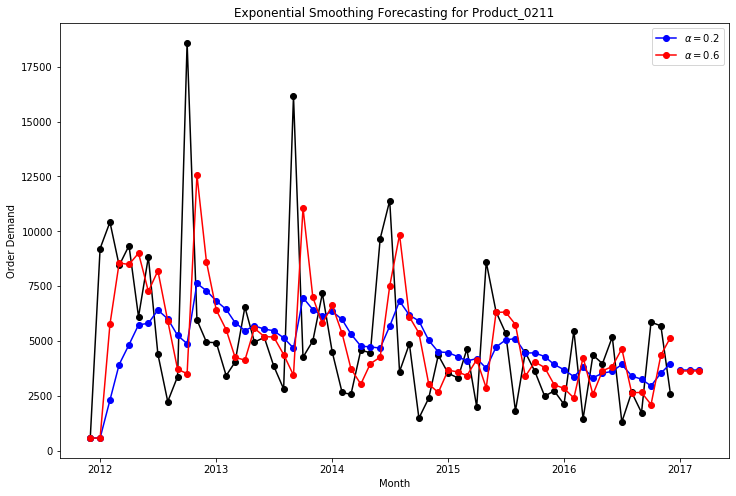

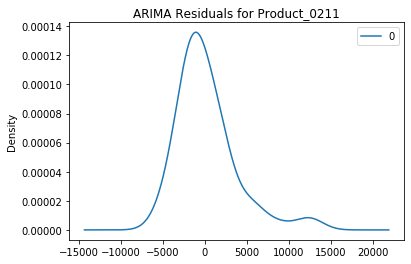

In [30]:
specProd = rawData[rawData['Product_Code'] == 'Product_0211']
specProd.sort_values(by=['Date'])
#plt.hist(specProd['Order_Demand'])

prod = []
for index, row in specProd.iterrows():
    if row['Order_Demand'][0] == '(':
        n = len(row['Order_Demand'])
        row['Order_Demand'] = row['Order_Demand'][1:n-1]
    prod.append(np.asarray(row))

specProd = pd.DataFrame(prod)
specProd.columns = ['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand']    
specProd['Order_Demand'] = pd.to_numeric(specProd['Order_Demand'])
#plt.plot(specProd['Date'], specProd['Order_Demand'])

#no of orders on a specific day
specProd['Orders'] = specProd.groupby('Date')['Product_Code'].transform('count')
specProd['Demand'] = specProd.groupby('Date')['Order_Demand'].transform('sum')
expSmoothingForecast(specProd, 'Product_0211')
ARIMAForecast(specProd, 'Product_0211')